In [ ]:
# Homework 3 (due 07/16/2024)

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

--------------------------------

In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time

## Part 1: Data preparation

In [108]:
# toggle settings
add_noise = False

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


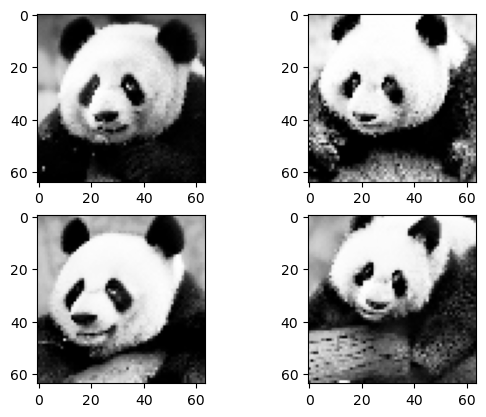

In [109]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

# Part 2: Singular value decomposition

In [110]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assume train_images is a list of 2D numpy arrays (grayscale images)
images_resized = [np.array(Image.fromarray(img).convert('L').resize((128, 128))) for img in train_images]

# Flatten each image to a 1D array and stack them into a matrix where each image is a row
images_matrix = np.stack([img.flatten() for img in images_resized])

# Compute the average image from the training data
avg_image = np.mean(images_matrix, axis=0)

# Subtract the average from each image to center the data
centered_images = images_matrix - avg_image
A = centered_images  # Now A should be (samples, features) i.e., (500, 16384) if you have 500 images

# Perform SVD on the mean-centered data
U, S, Vh = np.linalg.svd(A, full_matrices=False)


In [95]:
from PIL import Image
import numpy as np

# Resize images to 128x128 and convert them to numpy arrays, ensuring all images are grayscale
images_resized = [np.array(Image.fromarray(img).convert('L').resize((128, 128))) for img in train_images]

# Check image size
print("Resized image shape:", images_resized[0].shape)  # Should be (128, 128)

# Flatten each image to a 1D array and stack them into a matrix
images_matrix = np.stack([img.flatten() for img in images_resized])
print("Matrix shape:", images_matrix.shape)  # Should be (number of images, 128*128)


Resized image shape: (128, 128)
Matrix shape: (500, 16384)


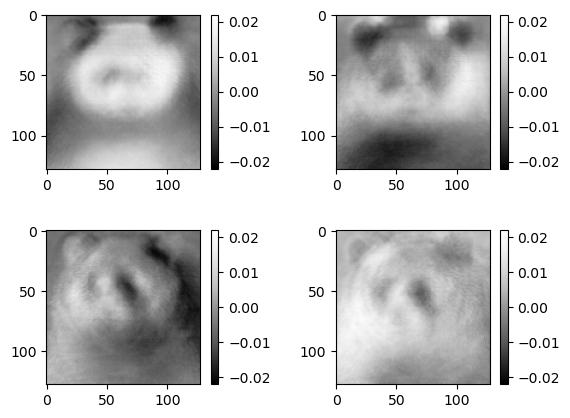

In [111]:
test_images_flat = [img.flatten() for img in test_images]  # Flatten each image
mean_image = np.mean(np.stack(test_images_flat), axis=0)  # Calculate mean from the training set or directly here if not done
centered_test_images = [img - mean_image for img in test_images_flat] 

for i in range(4):
    plt.subplot(2, 2, i + 1)
    # Reshape the ith row of Vh to the original image dimensions
    #change it to be vh based on the transpose to fit the original dimensions
    eigenbear = Vh[i].reshape((128, 128))
    #force colormap to be the same for all four
    plt.imshow(eigenbear, cmap='Greys_r', vmin=-np.max(np.abs(Vh[:4, :])), vmax=np.max(np.abs(Vh[:4, :])))
    plt.colorbar()  # Display colorbar for scale
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust space between plots for clarity
plt.show()

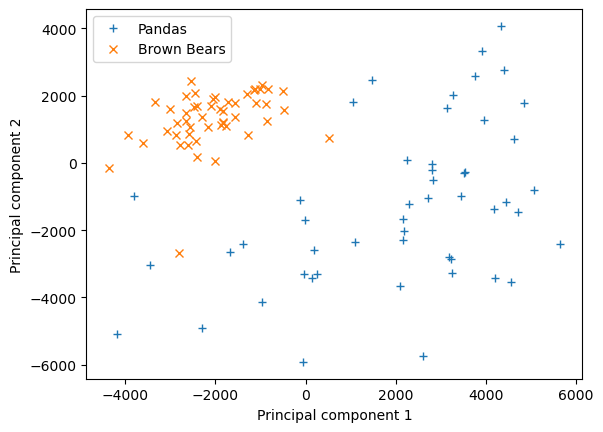

In [112]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # Get projections of data onto principal component 1
    p1 = [np.dot(Vh[0], centered_test_images[x]) for x in indices]  # Use the first row of Vh for PC1
    # Get projections of data onto principal component 2
    p2 = [np.dot(Vh[1], centered_test_images[x]) for x in indices]  # Use the second row of Vh for PC2
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Brown Bears'][i])

# Annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# Add legend
plt.legend()
plt.show()

# Part 3: Nonparametric classification

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [114]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [115]:
# Verify the shape of A
print("Shape of A before any operation:", A.shape)

# Ensure A is shaped (500, 16384), if not, transpose it correctly
if A.shape[0] != 500:
    A = A.T
    print("Transposed A for correct orientation, new shape:", A.shape)

# Now, fit the model with A without transposing
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')
for k in range(1, 16):
    # Fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(A, y_train)
    
    # Use model to make predictions on the test set
    # Ensure test images are also shaped correctly before prediction
    predictions = [modelKN.predict([centered_test_images[i]]) for i in range(len(y_test))]
    
    # Detect misclassifications
    errors = np.abs(np.array(predictions).flatten() - y_test)  # Ensure predictions are correctly flattened
    
    # Print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), np.argwhere(errors).T[0]))


Shape of A before any operation: (500, 16384)
   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      1 	| [39]
    2	|      0 	| []
    3	|      3 	| [24 39 42]
    4	|      2 	| [39 42]
    5	|      3 	| [36 39 42]
    6	|      3 	| [36 39 42]
    7	|      6 	| [11 22 36 39 41 42]
    8	|      5 	| [11 22 39 41 42]
    9	|      7 	| [ 6 11 22 36 39 41 42]
    10	|      5 	| [ 6 22 39 41 42]
    11	|      6 	| [ 6 22 24 39 41 42]
    12	|      6 	| [ 6 22 24 39 41 42]
    13	|      7 	| [ 6 11 22 24 39 41 42]
    14	|      7 	| [ 6 11 22 24 39 41 42]
    15	|      9 	| [ 6 11 21 22 24 36 39 41 42]


In [101]:
# Show hard-to-classify bears
'''ADD SOME CODE'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

best_k = None
best_accuracy = 0
accuracies = []

# Ensure A is shaped correctly and y_train is prepared
print("Shape of A:", A.shape)

# Iterate over a range of k values
for k in range(1, 16):
    modelKN = KNeighborsClassifier(n_neighbors=k)
    modelKN.fit(A, y_train)  # Ensure A is correctly shaped (500, 16384)
    predictions = modelKN.predict(centered_test_images)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)
    
    # Update best k if current k's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Best k: {best_k} with an accuracy of {best_accuracy:.2f}")

# Train model with the best k
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(A, y_train)

# Predict on the test set
best_predictions = best_model.predict(centered_test_images)


Shape of A: (500, 16384)
Best k: 2 with an accuracy of 1.00


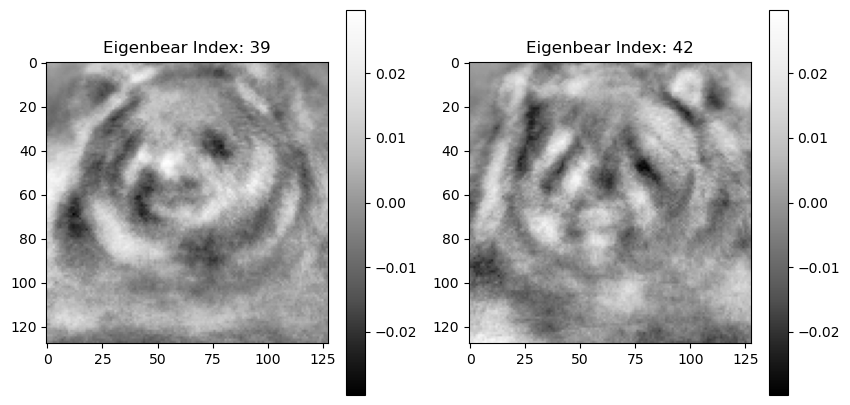

In [102]:
#plots to display
indices_to_display = [39, 42] 
num_plots = len(indices_to_display)
cols = 2 
rows = (num_plots + 1) // cols
plt.figure(figsize=(10, 5 * rows))

for i, index in enumerate(indices_to_display):
    plt.subplot(rows, cols, i + 1)
    eigenbear = Vh[index].reshape((128, 128))
    # Force colormap to be the same for all four by using the max absolute value from the selected Vh rows
    plt.imshow(eigenbear, cmap='Greys_r', vmin=-np.max(np.abs(Vh[indices_to_display, :])), vmax=np.max(np.abs(Vh[indices_to_display, :])))
    plt.colorbar()  # Display colorbar for scale
    plt.title(f'Eigenbear Index: {index}')

plt.show()


The eigenbears with the index 39 and 42 seem to be the most difficult to display. This is probably because the colors are pretty similar and there is a lot of blurrying make it hard to distinguish features. Also if the color is really similar then the pandas and bears will probably have a lot of overlap so KNN won't work well to differentiate them . 

# Part 4: Parametric classification

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [105]:
'''ADD SOME CODE'''
from sklearn.metrics import classification_report, confusion_matrix

#create the logistic model
logistic_model = LogisticRegression(max_iter=5000)
lda_model = LinearDiscriminantAnalysis()
qda_model = QuadraticDiscriminantAnalysis()

# Train the models
logistic_model.fit(A, y_train)
lda_model.fit(A, y_train)
qda_model.fit(A, y_train)

#predict
logistic_predictions = logistic_model.predict(test_images)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, logistic_predictions))

# LDA predictions and evaluation
lda_predictions = lda_model.predict(test_images)
print("LDA Classification Report:")
print(classification_report(y_test, lda_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, lda_predictions))

# QDA predictions and evaluation
qda_predictions = qda_model.predict(test_images)
print("QDA Classification Report:")
print(classification_report(y_test, qda_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, qda_predictions))


/Users/catherinechu/anaconda3/envs/mathai/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ValueError: Found array with dim 3. LogisticRegression expected <= 2.

In [106]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((modelLogReg.coef_).reshape((128,128))))
plt.colorbar()

NameError: name 'modelLogReg' is not defined